In [2]:
import pandas as pd
import numpy as np

# plotting 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

import sklearn 

import datetime as dt
from datetime import timedelta 
from datetime import date

# plotting candlestick graphs
import mplfinance as mpf

# used to retrieve ohlc and volume data for a stock from a website
import pandas_datareader.data as web


Performing quantitative analysis on a growth stock in the technology sector. Here, we'll be taking a look at Shopify, an e-commerce company and how its price has changed over time since its IPO. SHOP, listed on NYSE as well as TSX as (SHOP.TO), had IPO'd on May 21, 2015. 

In [3]:
style.use('ggplot')
# In this stock's case, the stock IPO'd in 2015
start = dt.datetime(2015,5,21)
# latest close date 
latest = date.today()
# retrieve data from Yahoo finance for the given dates
# DataReader is able to parse dates and indexes this column for us.
# otherwise, it'll be necessary to add parse_dates and index_col if reading a csv file.
df = web.DataReader('SHOP','yahoo',start,latest)
# datareader indexes date for us
print (df.tail(6))

                   High          Low         Open        Close   Volume  \
Date                                                                      
2020-08-03  1089.250000  1028.959961  1032.000000  1083.050049  2646600   
2020-08-04  1082.878052  1054.000000  1074.010010  1080.000000  1618400   
2020-08-05  1105.000000  1070.109985  1078.989990  1094.650024  1551600   
2020-08-06  1099.709961  1068.756958  1093.300049  1088.130005  1287200   
2020-08-07  1092.869995  1030.271973  1080.000000  1053.119995  1631200   
2020-08-10  1064.000000   987.409973  1055.000000  1005.559998  2368093   

              Adj Close  
Date                     
2020-08-03  1083.050049  
2020-08-04  1080.000000  
2020-08-05  1094.650024  
2020-08-06  1088.130005  
2020-08-07  1053.119995  
2020-08-10  1005.559998  


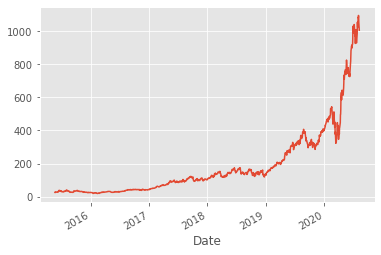

In [4]:
df['Adj Close'].plot()
# plt.show() 

Look at that beautiful curve! 
Since its IPO, SHOP has experienced explosive growth and recently, surpassed RBC on the TSX as the largest publicly listed company. From 17 to just shy of 1100 per share, a 64.7x fold increase since its IPO. 
Alright, let's dive in and do some technical analysis. 
Moving averages are an arithmetic mean of a certain number of data points over a given period of time. 50, 100 and 200 are the most common time periods used for analysis. Its common practice for many technical traders to use these averages to aid in choosing where to enter or exit a position, which then causes these levels to act as strong support or resistance.

Source: Investopedia.com
Note: I don't own any Shopify shares (although I wish I did!)

In [5]:
# Create column for Simple Moving average ('sma') for 100 days
# setting min_periods to 0 which will fill the values in 100d-sma column with close value instead of a NaN
df['100d-sma'] =  df['Adj Close'].rolling(window=100, min_periods=0).mean()
df.tail(100)

,High,Low,Open,Close,Volume,Adj Close,100d-sma
Date,,,,,,,
2020-03-19,345.730011,316.000000,336.160004,332.500000,3247200,332.500000,404.969300
2020-03-20,372.542999,342.000000,345.000000,346.059998,4295700,346.059998,405.255400
2020-03-23,384.179993,335.119995,346.540009,375.390015,3650900,375.390015,405.760000
2020-03-24,432.989990,406.670990,412.760010,430.000000,3504700,430.000000,406.934800
2020-03-25,470.570007,432.109985,435.940002,446.600006,3563200,446.600006,408.209600
...,...,...,...,...,...,...,...
2020-08-04,1082.878052,1054.000000,1074.010010,1080.000000,1618400,1080.000000,727.019201
2020-08-05,1105.000000,1070.109985,1078.989990,1094.650024,1551600,1094.650024,734.056702
2020-08-06,1099.709961,1068.756958,1093.300049,1088.130005,1287200,1088.130005,741.715102


We can plot multiple plots into one plot by using subplot, and get the adjusted closing value, the 100 day moving average and trading volume on the same plot. 

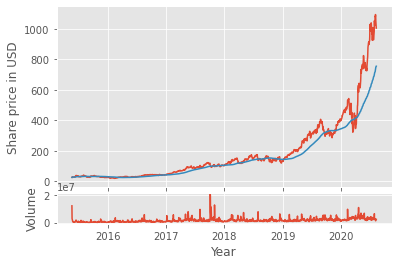

In [6]:
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=5, colspan=1)
ax2 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1,sharex=ax1)
ax1.plot(df.index, df['Adj Close'])
ax1.plot(df.index, df['100d-sma'])
ax2.plot(df.index, df['Volume'])
ax1.set_title
ax1.set(ylabel='Share price in USD')
ax2.set(ylabel='Volume')
ax2.set(xlabel='Year')

plt.show()

As shown above, the graph shows an exponential rise in share value with the 100 day moving average 

In [7]:
# Creating a candle-stick graph
# If a stock underwent a split, you'd have to create a new dataset based on the Adjusted Close values.
df_ohlc = df['Adj Close'].resample('10D').ohlc()
df_vol = df['Volume'].resample('10D').sum()
print (df_ohlc.tail())

                   open         high          low        close
Date                                                          
2020-06-23   911.340027  1029.969971   897.000000  1029.969971
2020-07-03   986.770020  1040.020020   986.770020  1031.859985
2020-07-13   968.750000  1009.390015   925.489990   957.330017
2020-07-23   928.409973  1053.589966   928.409973  1024.000000
2020-08-02  1083.050049  1094.650024  1005.559998  1005.559998


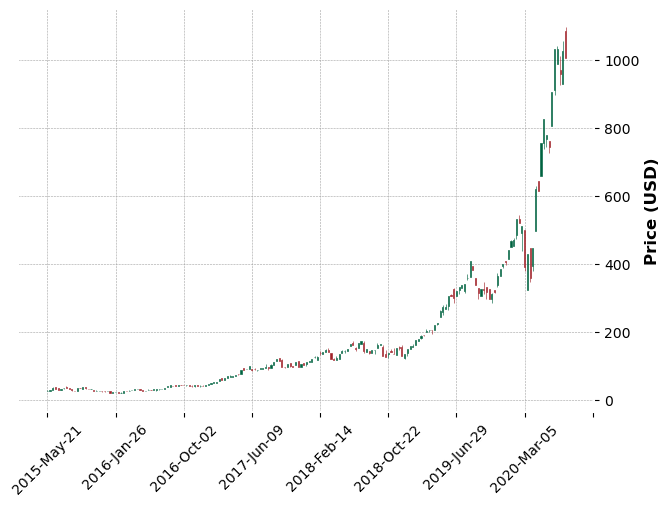

In [8]:
mpf.plot(
    df_ohlc, 
    type='candlestick',
    style='charles',
    ylabel='Price (USD)')


This is just a static candlestick graph that shows all the trading action since 2015. The red candles depict selling of the stock, the green indicates buying. 

2020-08-10 16:05:00.237368


True